## T-SNE model reconstruction(outputs)

## T-SNE Single Person Datasets Distribution

In [ ]:
import os
from typing import Any, Dict, Optional, Tuple

import torch
from lightning import LightningDataModule
from safetensors import safe_open
from torch.utils.data import ConcatDataset, DataLoader, Dataset, random_split

# from torchvision.datasets import MNIST
from torchvision.transforms import transforms

import torch
import os

# here we set a LoRADataset class
class LoRADataset(Dataset):
    """A PyTorch dataset for the LoRA dataset. Get a Tensor List."""
    def __init__(self, tensors):
        self.tensors = tensors

    def __len__(self):
        return len(self.tensors)

    def __getitem__(self, idx):
        tensor = self.tensors[idx]
        return tensor, tensor


class LoRADataModule(LightningDataModule):
    """`LightningDataModule` for the MNIST dataset. A `LightningDataModule` implements 7 key
    methods:

    ```python
        def prepare_data(self):
        # Things to do on 1 GPU/TPU (not on every GPU/TPU in DDP).
        # Download data, pre-process, split, save to disk, etc...

        def setup(self, stage):
        # Things to do on every process in DDP.
        # Load data, set variables, etc...

        def train_dataloader(self):
        # return train dataloader

        def val_dataloader(self):
        # return validation dataloader

        def test_dataloader(self):
        # return test dataloader

        def predict_dataloader(self):
        # return predict dataloader

    ```

    This allows you to share a full dataset without explaining how to download,
    split, transform and process the data.

    Read the docs:
        https://lightning.ai/docs/pytorch/latest/data/datamodule.html
    """

    def __init__(
        self,
        data_dir: str = "data/",
        predict_dir: str = "predict/",
        train_factor=0.7,
        val_factor=0.2,
        batch_size: int = 64,
        num_workers: int = 0,
        pin_memory: bool = False,
    ) -> None:
        """Initialize a `LoRADataModule`.

        :param data_dir: The data directory. Defaults to `"data/"`.
        :param train_val_test_split: The train, validation and test split. Defaults to `(55_000, 5_000, 10_000)`.
        :param batch_size: The batch size. Defaults to `64`.
        :param num_workers: The number of workers. Defaults to `0`.
        :param pin_memory: Whether to pin memory. Defaults to `False`.
        """
        super().__init__()

        # this line allows to access init params with 'self.hparams' attribute
        # also ensures init params will be stored in ckpt
        self.save_hyperparameters(logger=False)
        # data transformations
        self.transforms = transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
        )

        self.data_train: Optional[Dataset] = None
        self.data_val: Optional[Dataset] = None
        self.data_test: Optional[Dataset] = None
        self.data_predict: Optional[Dataset] = None

        self.batch_size_per_device = batch_size
        self.train_factor = train_factor
        self.val_factor = val_factor

    def load_and_flatten(self, file_path):
        # 加载.pt文件 若加载的数据是单个张量  TODO add times 10
        # tensors = []
        loaded_data = torch.load(file_path)
        # print("tamade"*20)
        if torch.is_tensor(loaded_data):
            flattened_tensor = loaded_data.flatten()
            # tensors.append(flattened_tensor)
            # print("tamade"*20)
            # sample_shape = tensors[0].shape
                    # 生成随机数据并添加到列表中
            # for _ in range(1):
                # random_tensor = torch.randn(sample_shape)  # 使用正态分布生成随机数据
                # tensors.append(random_tensor)
            return flattened_tensor
            # return torch.cat(tensors)
        # 若加载的数据是包含多个张量的字典
        tensors = []
        for k, tensor in loaded_data.items():
            flattened_tensor = tensor.flatten()
            tensors.append(flattened_tensor)
        # 获取一个张量的形状作为参考
        sample_shape = tensors[0].shape
        # 生成随机数据并添加到列表中
        for _ in range(1):
            random_tensor = torch.rand(sample_shape)
            # random_tensor = torch.randn(sample_shape)  # 使用正态分布生成随机数据
            tensors.append(random_tensor)

        # 将处理后的多个张量串联为一个张量
        return torch.cat(tensors) 


    
            

    def setup(self, stage: Optional[str] = None) -> None:
        """Load data. Set variables: `self.data_train`, `self.data_val`, `self.data_test`.

        This method is called by Lightning before `trainer.fit()`, `trainer.validate()`, `trainer.test()`, and
        `trainer.predict()`, so be careful not to execute things like random split twice! Also, it is called after
        `self.prepare_data()` and there is a barrier in between which ensures that all the processes proceed to
        `self.setup()` once the data is prepared and available for use.

        :param stage: The stage to setup. Either `"fit"`, `"validate"`, `"test"`, or `"predict"`. Defaults to ``None``.
        """
        # Divide batch size by the number of devices.
        if self.trainer is not None:
            if self.hparams.batch_size % self.trainer.world_size != 0:
                raise RuntimeError(
                    f"Batch size ({self.hparams.batch_size}) is not divisible by the number of devices ({self.trainer.world_size})."
                )
            self.batch_size_per_device = self.hparams.batch_size // self.trainer.world_size
        if stage == "predict" and self.hparams.predict_dir:
            file_paths = []
            for root, dirs, files in os.walk(self.hparams.predict_dir):
                for file in files:
                    if file.endswith(".pt"):
                        file_path = os.path.join(root, file)
                        file_paths.append(file_path)

            def add_random_data_to_flattened_tensors(flattened_tensors, num_random_samples=2220):
                """
                在 flattened_tensors 列表中加入指定数量的形状相同的随机数据张量。
                """
                print("Type of flattened_tensors:", type(flattened_tensors))
                print("First item in flattened_tensors:", flattened_tensors[0])
                # 检查 flattened_tensors 是否为空
                if not flattened_tensors:
                    print("flattened_tensors 是空的，无法确定形状。")
                    return
                
                print("caotamade"*20)
                # 获取一个张量的形状作为参考
                sample_shape = flattened_tensors[0].shape
                
                # 生成标准正态分布的随机数，然后调整其均值和标准差
                # x_normal =  torch.randn(2, 3) 
                sigma = 10 
                mu = 2
                
                # 生成随机数据并添加到列表中
                for _ in range(num_random_samples):
                    random_tensor = sigma * torch.randn(sample_shape) + mu # 使用正态分布生成随机数据
                    flattened_tensors.append(random_tensor)
                return flattened_tensors
            
            flattened_tensors = [self.load_and_flatten(path) for path in file_paths]
        #     # I want to random some data in to the flattened_tensors and the shape must be equal,write the code for me 
        #         # 假设你的 flattened_tensors 已经通过某种方式被填充
        # # 直接调用 add_random_data_to_flattened_tensors 函数来添加随机数据
        
            from labml.logger import inspect
            inspect(flattened_tensors)
            print("=="*20)
            
            self.flattened_tensors = add_random_data_to_flattened_tensors(flattened_tensors=flattened_tensors)
            
            inspect(self.flattened_tensors)
            
            self.data_predict = LoRADataset(self.flattened_tensors)
            
        elif stage in ['fit', 'validate', 'test'] and self.hparams.data_dir:
            if not self.data_train and not self.data_val and not self.data_test:
                file_paths = []
                for root, dirs, files in os.walk(self.hparams.data_dir):
                    for file in files:
                        if file.endswith(".pt"):
                            file_path = os.path.join(root, file)
                            file_paths.append(file_path)

                self.flattened_tensors = [self.load_and_flatten(path) for path in file_paths]
                dataset = LoRADataset(self.flattened_tensors)

                total_len = len(dataset)
                train_len = int(total_len * self.hparams.train_factor)
                val_len = int(total_len * self.hparams.val_factor)
                test_len = total_len - train_len - val_len
                self.data_train, self.data_val, self.data_test = random_split(
                    dataset,
                    [train_len, val_len, test_len],
                    generator=torch.Generator().manual_seed(42),
                )
  

    def train_dataloader(self) -> DataLoader[Any]:
        """Create and return the train dataloader.

        :return: The train dataloader.
        """
        return DataLoader(
            dataset=self.data_train,
            batch_size=self.batch_size_per_device,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            shuffle=True,
        )

    def val_dataloader(self) -> DataLoader[Any]:
        """Create and return the validation dataloader.

        :return: The validation dataloader.
        """
        return DataLoader(
            dataset=self.data_val,
            batch_size=self.batch_size_per_device,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            shuffle=False,
        )

    def test_dataloader(self) -> DataLoader[Any]:
        """Create and return the test dataloader.

        :return: The test dataloader.
        """
        return DataLoader(
            dataset=self.data_test,
            batch_size=self.batch_size_per_device,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            shuffle=False,
        )

    def predict_dataloader(self) -> DataLoader[Any]:
        return DataLoader(
            dataset=self.data_predict,
            batch_size=self.batch_size_per_device,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            shuffle=False,
        )
        
    def teardown(self, stage: Optional[str] = None) -> None:
        """Lightning hook for cleaning up after `trainer.fit()`, `trainer.validate()`,
        `trainer.test()`, and `trainer.predict()`.

        :param stage: The stage being torn down. Either `"fit"`, `"validate"`, `"test"`, or `"predict"`.
            Defaults to ``None``.
        """
        pass

    def state_dict(self) -> Dict[Any, Any]:
        """Called when saving a checkpoint. Implement to generate and save the datamodule state.

        :return: A dictionary containing the datamodule state that you want to save.
        """
        return {}

    def load_state_dict(self, state_dict: Dict[str, Any]) -> None:
        """Called when loading a checkpoint. Implement to reload datamodule state given datamodule
        `state_dict()`.

        :param state_dict: The datamodule state returned by `self.state_dict()`.
        """
        pass




## Test LoRA.pt


In [42]:
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def plot_with_tsne(data_loader, n_samples=1000):
    data_points = []

    for batch_idx, (data, _) in enumerate(data_loader):
        if len(data_points) >= n_samples:
            break
        data_points.append(data)

    # 将数据准备为适合 t-SNE 的形式
    X = torch.cat(data_points, 0).cpu().numpy()[:n_samples]

    # 执行 t-SNE 降维
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(X)

    # 绘图显示
    plt.figure(figsize=(16, 10))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.5)
    plt.show()

# 确保您有正确的 DataLoader
# plot_with_tsne(your_data_loader)


Type of flattened_tensors: <class 'list'>
First item in flattened_tensors: tensor([ 1.8600e-01,  3.4103e-01,  3.1545e-01,  ..., -3.9066e-03,
         1.8903e-04,  2.1968e-02])
caotamadecaotamadecaotamadecaotamadecaotamadecaotamadecaotamadecaotamadecaotamadecaotamadecaotamadecaotamadecaotamadecaotamadecaotamadecaotamadecaotamadecaotamadecaotamadecaotamade
Batch 0, Data shape: torch.Size([102, 372320])
Batch 1, Data shape: torch.Size([102, 372320])
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 13440 samples in 1.834s...


OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec

[t-SNE] Computed neighbors for 13440 samples in 338.243s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13440
[t-SNE] Computed conditional probabilities for sample 2000 / 13440
[t-SNE] Computed conditional probabilities for sample 3000 / 13440
[t-SNE] Computed conditional probabilities for sample 4000 / 13440
[t-SNE] Computed conditional probabilities for sample 5000 / 13440
[t-SNE] Computed conditional probabilities for sample 6000 / 13440
[t-SNE] Computed conditional probabilities for sample 7000 / 13440
[t-SNE] Computed conditional probabilities for sample 8000 / 13440
[t-SNE] Computed conditional probabilities for sample 9000 / 13440
[t-SNE] Computed conditional probabilities for sample 10000 / 13440
[t-SNE] Computed conditional probabilities for sample 11000 / 13440
[t-SNE] Computed conditional probabilities for sample 12000 / 13440
[t-SNE] Computed conditional probabilities for sample 13000 / 13440
[t-SNE] Computed conditional probabilities for sample 13440 / 134

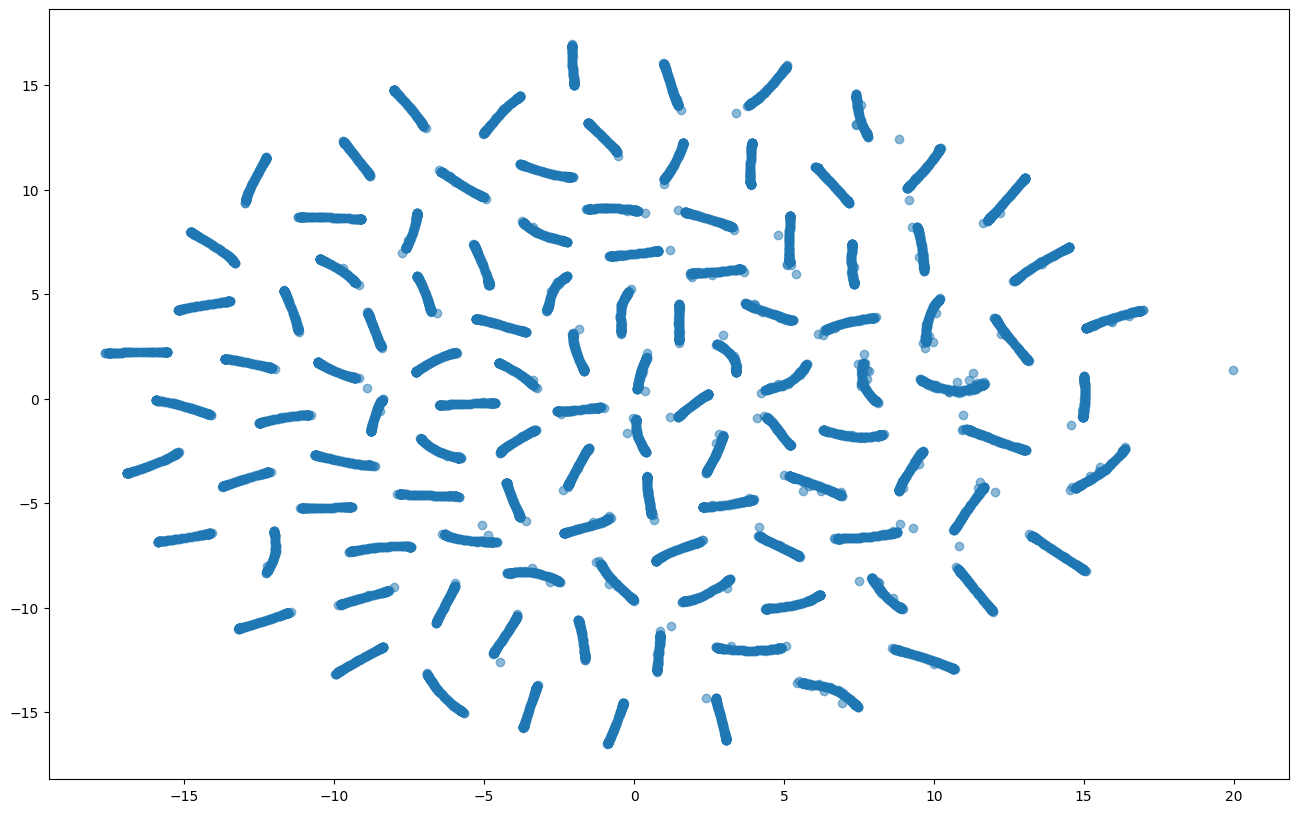

In [43]:

# LoRA_DataModule = LoRADataModule(predict_dir="/root/shiym_proj/DiffLook/notebooks/datasets/00118",batch_size=1,num_workers=0)
LoRA_DataModule = LoRADataModule(predict_dir="/root/shiym_proj/DiffLook/data/",batch_size=102,num_workers=0)

# Assuming `LoRA_DataModule` is your instance of LoRADataModule
# Make sure to call setup() to prepare your data
LoRA_DataModule.setup(stage="predict")

# For example, using the train dataset
predict_loader = LoRA_DataModule.predict_dataloader()

for i, (data, _) in enumerate(predict_loader):
    print(f"Batch {i}, Data shape: {data.shape}")
    if i >= 1: break  # 打印第一个批次信息，然后中断循环
# Now visualize using the function created
plot_with_tsne(predict_loader, n_samples=100000000)


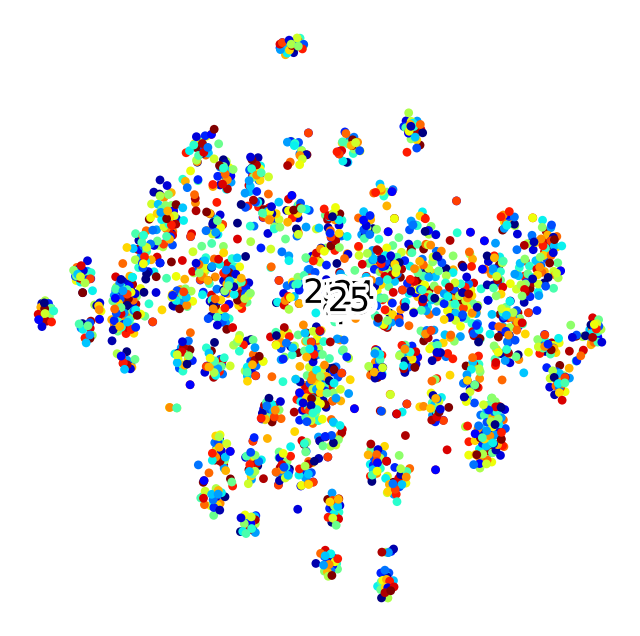

/root/anaconda3/envs/difflook/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


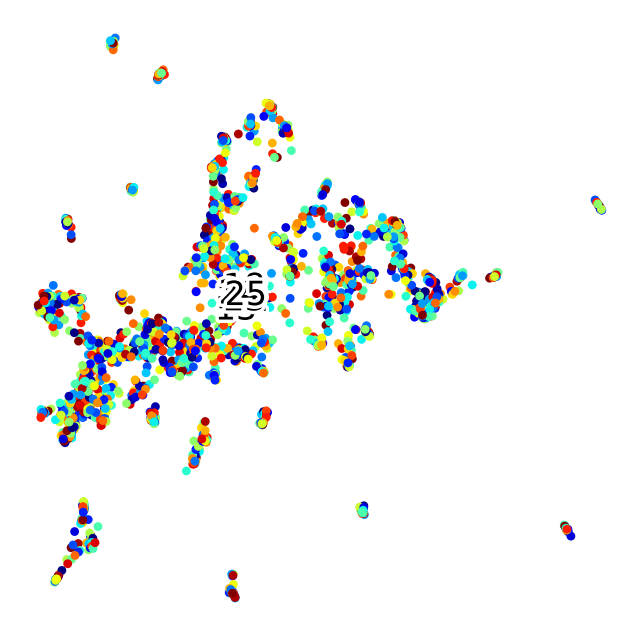